# ***Arrhythmia analysis***

---

<br>

### *The following code uses a Arrhythmia dataset with 280 features. Our objective is to show the results obtained when applied the **Decision Tree Classifier** and the **SVM Linear** from sckit-learn in order to classify the previously mentioned base.*

<br>

### *Steps developed in data pre-processing:*

<br>

### *1. Treating missing values*
### *2. Recognizing Outliers*
### *3. Normalizing*

<br>

### *In the last part, a variables analysis is performed considering the dataset's attributes. Besides that, we compared the outputs given by the different models mentioned and the selection methods utilized below:*

<br>

### *→ ReliefF*
### *→ InfoGain*
### *→ CFS*





## ***◾ Libraries***

---



In [155]:
!pip install git+https://github.com/jundongl/scikit-feature.git

  Cloning https://github.com/jundongl/scikit-feature.git to /tmp/pip-req-build-pxf4yoj6
  Running command git clone --filter=blob:none --quiet https://github.com/jundongl/scikit-feature.git /tmp/pip-req-build-pxf4yoj6
  Resolved https://github.com/jundongl/scikit-feature.git to commit 48cffad4e88ff4b9d2f1c7baffb314d1b3303792
  Preparing metadata (setup.py) ... done


In [156]:
# Reads arff files
from scipy.io import arff

# Manipulates tables
import pandas as pd
import numpy as np

# Fills the missing values
from sklearn.impute import SimpleImputer

# Method to find outliers
from sklearn.ensemble import IsolationForest

# Normalization
from sklearn.preprocessing import MaxAbsScaler

# Scaling
from sklearn.preprocessing import StandardScaler

# Selection methods
from sklearn.feature_selection import mutual_info_classif as mic
from skfeature.function.similarity_based.reliefF import reliefF
from skfeature.function.statistical_based.CFS import cfs

# Decision Tree classifier: model and evaluation metric
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Exports the outcomes
import matplotlib.pyplot as plt
from pandas.plotting import table

# Other classification models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

## ***◾ Dataset***


---



In [157]:
# Reads dataset
def ReadBase(path):
    dados = arff.loadarff(path)
    return pd.DataFrame(dados[0])

In [158]:
arq = 'arritmias_treino.arff'
X = ReadBase(arq)
X.head()

,Age,Sex,Height,Weight,QRS_duration,P-R,Q-T,T_interval,P_interval,QRS,...,Amp_V6_2,Amp_V6_3,Amp_V6_4,Amp_V6_5,Amp_V6_6,Amp_V6_7,Amp_V6_8,Amp_V6_9,Amp_V6_10,class
0,55.0,b'0',175.0,94.0,100.0,202.0,380.0,179.0,143.0,28.0,...,0.0,12.2,-2.2,0.0,0.0,0.4,2.6,34.6,61.6,b'1'
1,40.0,b'1',160.0,52.0,77.0,129.0,377.0,133.0,77.0,77.0,...,0.0,6.5,0.0,0.0,0.0,0.4,1.0,14.3,20.5,b'1'
2,49.0,b'1',162.0,54.0,78.0,0.0,376.0,157.0,70.0,67.0,...,0.0,8.2,-1.9,0.0,0.0,0.1,0.5,15.8,19.8,b'1'
3,44.0,b'0',168.0,56.0,84.0,118.0,354.0,160.0,63.0,61.0,...,0.0,7.0,-1.3,0.0,0.0,0.6,2.1,12.5,30.9,b'1'
4,45.0,b'1',165.0,86.0,77.0,143.0,373.0,150.0,65.0,12.0,...,0.0,4.4,-2.2,0.0,0.0,0.5,1.5,4.9,17.2,b'1'


## ***◾ Description of the dataset***


---



In [159]:
# Returns the categorical columns
def GetCategoricals(df):
    return df.select_dtypes(include='object')


# Returns numerical columns
def GetNumeric(df):
    return df._get_numeric_data()


# Missing data by register
def MissingRegisters(df):
    return df.isnull().sum(axis=1)


# Missing data by attribute
def MissingAttributes(df):
    return df.isnull().sum()


# Missing data in general
def MissingData(df):
    return MissingRegisters(df), MissingAttributes(df)


# Classifying the numerical columns regarding cardinality:
# discrete, continue or binary)
def ClassifyCardinality(df):
    discretos, continuos = list(), list()

    for atributo in df.columns.values:
        # Unique values
        unique_count = df[atributo].nunique()

        # Defining a criteria
        if unique_count <= 10:
            discretos.append(atributo)
        else:
            continuos.append(atributo)

        return discretos, continuos

In [160]:
X_num = GetNumeric(X)
X_cat = GetCategoricals(X)

In [161]:
X_cat

,Sex,Existence_ragged_R_wave,Existence_diphasic_derivation_R_wave,Existence_ragged_P_wave,Existence_diphasic_drivation_P_wave,Existence_ragged_T_wave,Existence_diphasic_derivation_T_wave,class
0,b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'1'
1,b'1',b'0',b'0',b'0',b'0',b'0',b'0',b'1'
2,b'1',b'0',b'0',b'0',b'0',b'0',b'0',b'1'
3,b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'1'
4,b'1',b'0',b'0',b'0',b'0',b'0',b'0',b'1'
...,...,...,...,...,...,...,...,...
397,b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'10'
398,b'1',b'0',b'0',b'0',b'0',b'0',b'0',b'1'
399,b'1',b'0',b'0',b'0',b'0',b'0',b'0',b'1'
400,b'1',b'0',b'0',b'0',b'0',b'0',b'0',b'15'


In [162]:
X_num

,Age,Height,Weight,QRS_duration,P-R,Q-T,T_interval,P_interval,QRS,T,...,Amp_V6_1,Amp_V6_2,Amp_V6_3,Amp_V6_4,Amp_V6_5,Amp_V6_6,Amp_V6_7,Amp_V6_8,Amp_V6_9,Amp_V6_10
0,55.0,175.0,94.0,100.0,202.0,380.0,179.0,143.0,28.0,11.0,...,0.1,0.0,12.2,-2.2,0.0,0.0,0.4,2.6,34.6,61.6
1,40.0,160.0,52.0,77.0,129.0,377.0,133.0,77.0,77.0,49.0,...,-0.4,0.0,6.5,0.0,0.0,0.0,0.4,1.0,14.3,20.5
2,49.0,162.0,54.0,78.0,0.0,376.0,157.0,70.0,67.0,7.0,...,-0.3,0.0,8.2,-1.9,0.0,0.0,0.1,0.5,15.8,19.8
3,44.0,168.0,56.0,84.0,118.0,354.0,160.0,63.0,61.0,69.0,...,0.1,0.0,7.0,-1.3,0.0,0.0,0.6,2.1,12.5,30.9
4,45.0,165.0,86.0,77.0,143.0,373.0,150.0,65.0,12.0,37.0,...,0.1,0.0,4.4,-2.2,0.0,0.0,0.5,1.5,4.9,17.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397,65.0,172.0,66.0,98.0,199.0,339.0,149.0,181.0,-4.0,136.0,...,-1.1,0.0,15.0,-4.5,0.0,0.0,0.2,-0.4,26.4,23.0
398,50.0,163.0,65.0,75.0,151.0,362.0,137.0,93.0,43.0,33.0,...,-0.3,-0.4,5.1,-1.3,0.0,0.0,0.7,1.0,6.2,11.6
399,27.0,160.0,42.0,78.0,153.0,374.0,165.0,85.0,23.0,61.0,...,1.4,-0.7,12.2,-2.4,0.0,0.0,0.5,1.9,11.0,25.0
400,58.0,160.0,90.0,82.0,0.0,284.0,196.0,0.0,56.0,-132.0,...,-0.8,0.0,14.5,-2.3,0.0,0.0,0.2,-1.7,30.2,16.0


In [163]:
# Information
X.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402 entries, 0 to 401
Data columns (total 280 columns):
 #    Column                                     Non-Null Count  Dtype  
---   ------                                     --------------  -----  
 0    Age                                        402 non-null    float64
 1    Sex                                        402 non-null    object 
 2    Height                                     402 non-null    float64
 3    Weight                                     402 non-null    float64
 4    QRS_duration                               402 non-null    float64
 5    P-R                                        402 non-null    float64
 6    Q-T                                        402 non-null    float64
 7    T_interval                                 402 non-null    float64
 8    P_interval                                 402 non-null    float64
 9    QRS                                        402 non-null    float64
 10   T           

In [164]:
# Missing data
missing_reg, missing_att = MissingData(X_num)

In [165]:
missing_reg

0      1
1      1
2      1
3      0
4      1
      ..
397    1
398    1
399    1
400    2
401    1
Length: 402, dtype: int64

In [166]:
missing_att

Age             0
Height          0
Weight          0
QRS_duration    0
P-R             0
               ..
Amp_V6_6        0
Amp_V6_7        0
Amp_V6_8        0
Amp_V6_9        0
Amp_V6_10       0
Length: 272, dtype: int64

In [167]:
# Exporting the results found to excel
missing_reg.to_excel('MissingDataRegister.xlsx',
                     index_label = "Registers", header=['Missing Data'])
missing_att.to_excel('MissingDataAttribute.xlsx',
                     index_label = "Attributes", header=['Missing Data'])

In [168]:
# Verifying the cardinality
disc, cont = ClassifyCardinality(X_num)

print(f"Discrete attributes:\n{disc}")
print(f"\nContinue attributes:\n{cont}")

Discrete attributes:
[]

Continue attributes:
['Age']


In [169]:
# Describing the attributes
desc = X.describe()
desc = desc.drop(['25%', '50%', '75%'], axis=0)
print(desc)

              Age      Height      Weight  QRS_duration         P-R  \
count  402.000000  402.000000  402.000000    402.000000  402.000000   
mean    46.883085  166.343284   68.475124     88.721393  155.579602   
std     16.213776   39.136777   16.603206     15.312603   46.368091   
min      0.000000  105.000000    6.000000     61.000000    0.000000   
max     83.000000  780.000000  176.000000    188.000000  524.000000   

              Q-T  T_interval  P_interval         QRS           T  ...  \
count  402.000000  402.000000  402.000000  402.000000  394.000000  ...   
mean   366.564677  169.054726   90.238806   34.927861   34.565990  ...   
std     34.153636   34.178306   26.689359   43.574253   59.526263  ...   
min    232.000000  108.000000    0.000000 -172.000000 -177.000000  ...   
max    509.000000  327.000000  205.000000  169.000000  179.000000  ...   

         Amp_V6_1    Amp_V6_2    Amp_V6_3    Amp_V6_4    Amp_V6_5  Amp_V6_6  \
count  402.000000  402.000000  402.000000  402.00

## ***◾ Pre-processing***


---



### ***▪️   1. Identifying the entries ( X ) and the target ( y )***


---

In [170]:
# Dividing the dataframe
def InputOutput(df, target):
    return df[target].astype('int'), df.drop([target], axis=1)

In [171]:
y, X = InputOutput(X, 'class')

### ***▪️   2. Missing Values***


---

In [172]:
# Treats the categorical variables
def VerifyCats(df):
    imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    return imp_mode.fit_transform(df)


# Treats the numericals columns
def VerifyNums(df):
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
    return imp_mean.fit_transform(df)


# Transforms categorical columns into numerical
def BinToNum(df, cols):
    for col in cols:
        df[col] = list(map(lambda x: int(x.decode('UTF-8')), df[col]))

In [173]:
nan_columns = MissingAttributes(X)
nan_columns

Age             0
Sex             0
Height          0
Weight          0
QRS_duration    0
               ..
Amp_V6_6        0
Amp_V6_7        0
Amp_V6_8        0
Amp_V6_9        0
Amp_V6_10       0
Length: 279, dtype: int64

In [174]:
# In this part, we will remove the column 'J' on the grounds that it has
# a bewildering number of NaNs
X = X.drop('J', axis=1)

In [175]:
# Spliting the dataframe in categoricals and numericals
X_cat = GetCategoricals(X)
X_num = GetNumeric(X)

In [176]:
X_cat.head()

,Sex,Existence_ragged_R_wave,Existence_diphasic_derivation_R_wave,Existence_ragged_P_wave,Existence_diphasic_drivation_P_wave,Existence_ragged_T_wave,Existence_diphasic_derivation_T_wave
0,b'0',b'0',b'0',b'0',b'0',b'0',b'0'
1,b'1',b'0',b'0',b'0',b'0',b'0',b'0'
2,b'1',b'0',b'0',b'0',b'0',b'0',b'0'
3,b'0',b'0',b'0',b'0',b'0',b'0',b'0'
4,b'1',b'0',b'0',b'0',b'0',b'0',b'0'


In [177]:
X_num.head()

,Age,Height,Weight,QRS_duration,P-R,Q-T,T_interval,P_interval,QRS,T,...,Amp_V6_1,Amp_V6_2,Amp_V6_3,Amp_V6_4,Amp_V6_5,Amp_V6_6,Amp_V6_7,Amp_V6_8,Amp_V6_9,Amp_V6_10
0,55.0,175.0,94.0,100.0,202.0,380.0,179.0,143.0,28.0,11.0,...,0.1,0.0,12.2,-2.2,0.0,0.0,0.4,2.6,34.6,61.6
1,40.0,160.0,52.0,77.0,129.0,377.0,133.0,77.0,77.0,49.0,...,-0.4,0.0,6.5,0.0,0.0,0.0,0.4,1.0,14.3,20.5
2,49.0,162.0,54.0,78.0,0.0,376.0,157.0,70.0,67.0,7.0,...,-0.3,0.0,8.2,-1.9,0.0,0.0,0.1,0.5,15.8,19.8
3,44.0,168.0,56.0,84.0,118.0,354.0,160.0,63.0,61.0,69.0,...,0.1,0.0,7.0,-1.3,0.0,0.0,0.6,2.1,12.5,30.9
4,45.0,165.0,86.0,77.0,143.0,373.0,150.0,65.0,12.0,37.0,...,0.1,0.0,4.4,-2.2,0.0,0.0,0.5,1.5,4.9,17.2


In [178]:
X_num = VerifyNums(X_num)
X_cat = VerifyCats(X_cat)

In [179]:
# Retransforming the numpy arrays into dataframes
X_cat = pd.DataFrame(X_cat, columns = X.select_dtypes(include='object').columns)
X_num = pd.DataFrame(X_num, columns = X.select_dtypes(include=np.number).columns)

X = pd.concat([X_cat, X_num], axis=1)
X.head()

,Sex,Existence_ragged_R_wave,Existence_diphasic_derivation_R_wave,Existence_ragged_P_wave,Existence_diphasic_drivation_P_wave,Existence_ragged_T_wave,Existence_diphasic_derivation_T_wave,Age,Height,Weight,...,Amp_V6_1,Amp_V6_2,Amp_V6_3,Amp_V6_4,Amp_V6_5,Amp_V6_6,Amp_V6_7,Amp_V6_8,Amp_V6_9,Amp_V6_10
0,b'0',b'0',b'0',b'0',b'0',b'0',b'0',55.0,175.0,94.0,...,0.1,0.0,12.2,-2.2,0.0,0.0,0.4,2.6,34.6,61.6
1,b'1',b'0',b'0',b'0',b'0',b'0',b'0',40.0,160.0,52.0,...,-0.4,0.0,6.5,0.0,0.0,0.0,0.4,1.0,14.3,20.5
2,b'1',b'0',b'0',b'0',b'0',b'0',b'0',49.0,162.0,54.0,...,-0.3,0.0,8.2,-1.9,0.0,0.0,0.1,0.5,15.8,19.8
3,b'0',b'0',b'0',b'0',b'0',b'0',b'0',44.0,168.0,56.0,...,0.1,0.0,7.0,-1.3,0.0,0.0,0.6,2.1,12.5,30.9
4,b'1',b'0',b'0',b'0',b'0',b'0',b'0',45.0,165.0,86.0,...,0.1,0.0,4.4,-2.2,0.0,0.0,0.5,1.5,4.9,17.2


In [180]:
# Verifying if the NaNs were corrected
print(GetNaNs(X))

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]

[402 rows x 0 columns]


In [181]:
# Converting categorical to numerical
BinToNum(X, X_cat.columns.to_list())
X.head()

,Sex,Existence_ragged_R_wave,Existence_diphasic_derivation_R_wave,Existence_ragged_P_wave,Existence_diphasic_drivation_P_wave,Existence_ragged_T_wave,Existence_diphasic_derivation_T_wave,Age,Height,Weight,...,Amp_V6_1,Amp_V6_2,Amp_V6_3,Amp_V6_4,Amp_V6_5,Amp_V6_6,Amp_V6_7,Amp_V6_8,Amp_V6_9,Amp_V6_10
0,0,0,0,0,0,0,0,55.0,175.0,94.0,...,0.1,0.0,12.2,-2.2,0.0,0.0,0.4,2.6,34.6,61.6
1,1,0,0,0,0,0,0,40.0,160.0,52.0,...,-0.4,0.0,6.5,0.0,0.0,0.0,0.4,1.0,14.3,20.5
2,1,0,0,0,0,0,0,49.0,162.0,54.0,...,-0.3,0.0,8.2,-1.9,0.0,0.0,0.1,0.5,15.8,19.8
3,0,0,0,0,0,0,0,44.0,168.0,56.0,...,0.1,0.0,7.0,-1.3,0.0,0.0,0.6,2.1,12.5,30.9
4,1,0,0,0,0,0,0,45.0,165.0,86.0,...,0.1,0.0,4.4,-2.2,0.0,0.0,0.5,1.5,4.9,17.2


### ***▪️ 3.   Recognizing Outliers***


---

In [182]:
# Returns the outliers index
def FindOutliers(df):
    df_copy = df.copy()

    # Model Isolation Florest
    model = IsolationForest(n_estimators=50, max_samples='auto',
                        contamination=float(0.1), max_features=1.0,
                         random_state=3)

    # Feeding the model
    model.fit(df)

    # New variables
    df_copy['Scores'] = model.decision_function(df)
    df_copy['Outliers'] = model.predict(df)

    # Detecting the outliers
    outliers = df_copy.loc[df_copy['Outliers'] == -1]

    return list(outliers.index)

In [183]:
outliers_index = FindOutliers(X)
print(f'We found {len(outliers_index)} outliers:\n\n{outliers_index}')

We found 41 outliers:

[40, 56, 65, 68, 69, 82, 88, 109, 121, 138, 167, 169, 178, 184, 187, 190, 193, 198, 232, 233, 237, 271, 276, 277, 280, 283, 292, 296, 307, 328, 334, 336, 341, 350, 359, 361, 368, 375, 378, 383, 392]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [184]:
# Removing the registers that are outliers
X = X.drop(outliers_index, axis=0)
y = y.drop(outliers_index, axis=0)

In [185]:
X

,Sex,Existence_ragged_R_wave,Existence_diphasic_derivation_R_wave,Existence_ragged_P_wave,Existence_diphasic_drivation_P_wave,Existence_ragged_T_wave,Existence_diphasic_derivation_T_wave,Age,Height,Weight,...,Amp_V6_1,Amp_V6_2,Amp_V6_3,Amp_V6_4,Amp_V6_5,Amp_V6_6,Amp_V6_7,Amp_V6_8,Amp_V6_9,Amp_V6_10
0,0,0,0,0,0,0,0,55.0,175.0,94.0,...,0.1,0.0,12.2,-2.2,0.0,0.0,0.4,2.6,34.6,61.6
1,1,0,0,0,0,0,0,40.0,160.0,52.0,...,-0.4,0.0,6.5,0.0,0.0,0.0,0.4,1.0,14.3,20.5
2,1,0,0,0,0,0,0,49.0,162.0,54.0,...,-0.3,0.0,8.2,-1.9,0.0,0.0,0.1,0.5,15.8,19.8
3,0,0,0,0,0,0,0,44.0,168.0,56.0,...,0.1,0.0,7.0,-1.3,0.0,0.0,0.6,2.1,12.5,30.9
4,1,0,0,0,0,0,0,45.0,165.0,86.0,...,0.1,0.0,4.4,-2.2,0.0,0.0,0.5,1.5,4.9,17.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397,0,0,0,0,0,0,0,65.0,172.0,66.0,...,-1.1,0.0,15.0,-4.5,0.0,0.0,0.2,-0.4,26.4,23.0
398,1,0,0,0,0,0,0,50.0,163.0,65.0,...,-0.3,-0.4,5.1,-1.3,0.0,0.0,0.7,1.0,6.2,11.6
399,1,0,0,0,0,0,0,27.0,160.0,42.0,...,1.4,-0.7,12.2,-2.4,0.0,0.0,0.5,1.9,11.0,25.0
400,1,0,0,0,0,0,0,58.0,160.0,90.0,...,-0.8,0.0,14.5,-2.3,0.0,0.0,0.2,-1.7,30.2,16.0


In [186]:
y

0       1
1       1
2       1
3       1
4       1
       ..
397    10
398     1
399     1
400    15
401     1
Name: class, Length: 361, dtype: int64

### ***▪️ 4.   Normalization***


---

In [187]:
# Normalizing the dataframe
def Normalize(df):
    columns = df.columns
    df = MaxAbsScaler().fit_transform(df)
    return pd.DataFrame(df, columns = columns)

In [188]:
X = Normalize(X)

In [189]:
X

,Sex,Existence_ragged_R_wave,Existence_diphasic_derivation_R_wave,Existence_ragged_P_wave,Existence_diphasic_drivation_P_wave,Existence_ragged_T_wave,Existence_diphasic_derivation_T_wave,Age,Height,Weight,...,Amp_V6_1,Amp_V6_2,Amp_V6_3,Amp_V6_4,Amp_V6_5,Amp_V6_6,Amp_V6_7,Amp_V6_8,Amp_V6_9,Amp_V6_10
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.662651,0.930851,0.758065,...,0.041667,0.000000,0.516949,-0.338462,0.0,0.0,0.285714,0.433333,0.613475,0.631148
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.481928,0.851064,0.419355,...,-0.166667,0.000000,0.275424,0.000000,0.0,0.0,0.285714,0.166667,0.253546,0.210041
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.590361,0.861702,0.435484,...,-0.125000,0.000000,0.347458,-0.292308,0.0,0.0,0.071429,0.083333,0.280142,0.202869
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.530120,0.893617,0.451613,...,0.041667,0.000000,0.296610,-0.200000,0.0,0.0,0.428571,0.350000,0.221631,0.316598
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.542169,0.877660,0.693548,...,0.041667,0.000000,0.186441,-0.338462,0.0,0.0,0.357143,0.250000,0.086879,0.176230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.783133,0.914894,0.532258,...,-0.458333,0.000000,0.635593,-0.692308,0.0,0.0,0.142857,-0.066667,0.468085,0.235656
357,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.602410,0.867021,0.524194,...,-0.125000,-0.166667,0.216102,-0.200000,0.0,0.0,0.500000,0.166667,0.109929,0.118852
358,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.325301,0.851064,0.338710,...,0.583333,-0.291667,0.516949,-0.369231,0.0,0.0,0.357143,0.316667,0.195035,0.256148
359,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.698795,0.851064,0.725806,...,-0.333333,0.000000,0.614407,-0.353846,0.0,0.0,0.142857,-0.283333,0.535461,0.163934


## ***◾ Implementing the Decision Tree model***


---



### ***▪️ 1.   Variables selection***


---

#### ***- Relief***

In [190]:
# ReliefF method
def ReliefF(dataframe, labels):
    weights = reliefF(dataframe.values, labels.values, k=5)

    # New dataframe with the weights
    weights_2d = np.reshape(weights, (1, -1))
    new_df = pd.DataFrame(weights_2d, columns = dataframe.columns)

    values = [new_df[col][0] for col in new_df.columns.values]

    return pd.DataFrame({'Importances - ReliefF': values},
                          index = dataframe.columns)


# Remove the columns based on a threshold
def RemoveUseless(df, imp, threshold):
    new_df = df.copy()
    cols = list(df.columns)
    useless_cols = list()

    for i in range(len(cols)):
        if imp[i] < threshold:
            useless_cols.append(cols[i])

    return new_df.drop(useless_cols, axis=1)


# Returns the base after removing the non selected columns
def SelectVar(X, y, method, threshold):
    imp = list(method(X, y)[f'Importances - {method.__name__}'])
    return RemoveUseless(X, imp, threshold)

#### ***- Gain***

In [191]:
# Gain method
def Gain(X, y):
    columns = X.columns
    imps = mic(X, y, random_state=3)
    porcents = list(map(lambda x: x*100, imps))
    return pd.DataFrame({'Importances - Gain': porcents},
                                index=columns)

#### ***- CFS***

In [192]:
# CFS model
def Cfs(df, target):
    X = df.values
    y = target.values

    selected_features = cfs(X, y)
    selected_columns = df.columns[selected_features]

    return pd.DataFrame(X[:, selected_features], columns=selected_columns)

### ***▪️ 2.   Training the model***


---

In [193]:
# Trains the model using a defined variables selection method
def TrainModel(X, y, model, method):
    # Identifying the methods
    if method.__name__ == 'Cfs':
        X = Cfs(X, y)
    else:
        X = SelectVar(X, y, method, 0.5)

    # Dividing the dataset for train and validation
    X_train, X_val, y_train, y_val = train_test_split(X,
    y, test_size = 0.2, random_state = 3)

    # Feeding the new model
    new_model = model
    new_model.fit(X_train, y_train)

    return new_model, X_val, y_val

### ***▪️ 3.   Analyzing the outcomes***


---

In [194]:
# Verifies the accuracy of the model
def Accuracy(model, x1, y1):
    y2 = model.predict(x1)
    return round(accuracy_score(y1, y2) * 100, 3)


# Calculates the accuracy of the model without selecting variables
def Default(X, y, model):
    # Spliting the dataframe
    X_train, X_val, y_train, y_val = train_test_split(X,
    y, test_size = 0.2, random_state = 3)

    model.fit(X_train, y_train)

    return Accuracy(model, X_val, y_val)


# Calculates the accuracy of the different models created
def Outcomes(X, y, methods, model):
    table = {"Default (%)":[Default(X, y, model)]}

    # Distinct methods
    for method in methods:
        new_model, X_val, y_val = TrainModel(X, y, model, method)
        table[method.__name__ + ' (%)'] = Accuracy(new_model, X_val, y_val)

    return pd.DataFrame(table, index = ['Accuracy'])

In [195]:
# Methods developed before
methods = [Gain, ReliefF, Cfs]

# The Decision Tree Model
model_DTC = DTC(random_state = 3, max_depth = 5, criterion='entropy')

# Table with the accuracies
results = Outcomes(X, y, methods, model_DTC)

### ***▪️ 4.   Exporting the results***


---

In [196]:
# Converts the dataframe to image
def ToImage(df, path):
    # Changes the size of the figure
    fig, ax = plt.subplots(figsize=(12, 1))

    # Hides the x axis
    ax.xaxis.set_visible(False)

    # Hides the y axis
    ax.yaxis.set_visible(False)

    # No visible frame
    ax.set_frame_on(False)

    t = table(ax, df, loc='upper right', colWidths=[0.17]*len(df.columns))
    t.auto_set_font_size(False)
    t.set_fontsize(12)

    # Changes the size of the table
    t.scale(1.5, 1.5)

    plt.savefig(path, transparent=True)

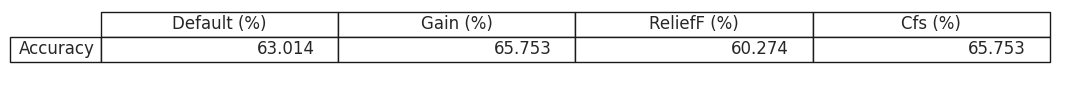

In [197]:
ToImage(results, 'tableDTC.png')

## ***◾ Comparing other classification models***


---



### ***▪️ 1. Models Accuracies***

In [198]:
# Spliting the Dataframe
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state = 3)

In [199]:
names = ["Nearest_Neighbors", "Linear_SVM", "Polynomial_SVM", "RBF_SVM",
         "Gaussian_Process", "Gradient_Boosting", "Random_Forest",
         "AdaBoost", "Naive_Bayes"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C = 0.025),
    SVC(kernel="poly", degree=3, C=0.025),
    SVC(kernel="rbf", C=1, gamma=2),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    GradientBoostingClassifier(n_estimators=100, learning_rate=1.0),
    RandomForestClassifier(max_depth=5, n_estimators=100),
    AdaBoostClassifier(n_estimators=100),
    GaussianNB()]

In [200]:
accuracies = []

for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    accuracies.append(Accuracy(clf, X_test, y_test))

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [201]:
accuracies

[56.164, 64.384, 64.384, 64.384, 64.384, 65.753, 65.753, 63.014, 13.699]

In [202]:
classifiers_accuracies = pd.DataFrame({'Name':names, 'Accuracy':accuracies})
classifiers_accuracies

,Name,Accuracy
0,Nearest_Neighbors,56.164
1,Linear_SVM,64.384
2,Polynomial_SVM,64.384
3,RBF_SVM,64.384
4,Gaussian_Process,64.384
5,Gradient_Boosting,65.753
6,Random_Forest,65.753
7,AdaBoost,63.014
8,Naive_Bayes,13.699


### ***▪️ 2. Graphic Analysis***


In [203]:
import seaborn as sns

In [204]:
color_map = sns.light_palette("red", as_cmap=True)
classifiers_accuracies.style.background_gradient(cmap=color_map)

,Name,Accuracy
0,Nearest_Neighbors,56.164000
1,Linear_SVM,64.384000
2,Polynomial_SVM,64.384000
3,RBF_SVM,64.384000
4,Gaussian_Process,64.384000
5,Gradient_Boosting,65.753000
6,Random_Forest,65.753000
7,AdaBoost,63.014000
8,Naive_Bayes,13.699000


<Axes: xlabel='Accuracy', ylabel='Name'>

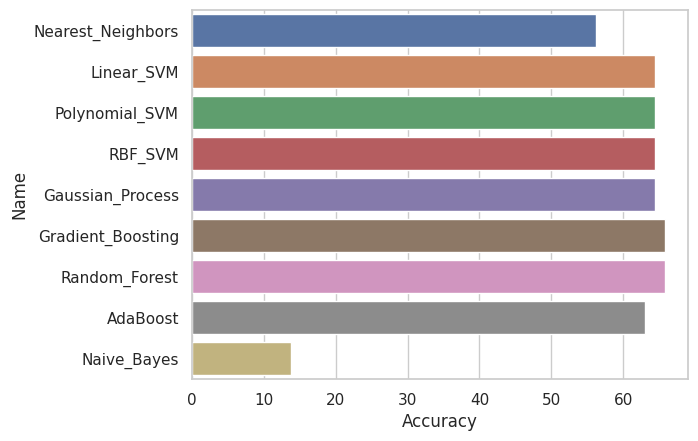

In [205]:
sns.set(style="whitegrid")
sns.barplot(y="Name", x="Accuracy", data=classifiers_accuracies)

## ***◾Implementing the model SVM Linear***

---

In [206]:
model_svm_linear = SVC(kernel="linear", C=0.025)

In [153]:
results = Outcomes(X, y, methods, model_svm_linear)

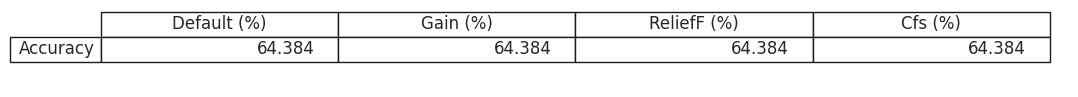

In [154]:
ToImage(results, 'tableSVMLinear.png')